In [38]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [39]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [ ]:
spark = SparkSession.builder.master("local[2]").appName("Youtube-Data-Analysis").getOrCreate()

In [41]:
spark

In [42]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Youtube-Data-Analysis>

In [43]:
time_df = spark.read.csv("./data/preprocessed_data.csv", header=True, inferSchema=True).cache()

In [44]:
time_df.take(5)

[Row(_c0=0, video_id='Jw1Y-zhQURU', trending_date=datetime.date(2017, 11, 14), title='John Lewis Christmas Ad 2017 - #MozTheMonster', channel_title='John Lewis', category_id='Howto & Style', publish_time=datetime.datetime(2017, 11, 10, 7, 38, 29), tags='"""christmas|""""john lewis christmas""""|""""john lewis""""|""""christmas ad""""|""""mozthemonster""""|""""christmas 2017""""|""""christmas ad 2017""""|""""john lewis christmas advert""""|""""moz"""""""', views=7224515, likes=55681, dislikes=10247, comment_count=9479, description="Click here to continue the story and make your own monster:\\nhttp://bit.ly/2mboXgj\\n\\nJoe befriends a noisy Monster under his bed but the two have so much fun together that he can't get to sleep, leaving him tired by day. For Christmas Joe receives a gift to help him finally get a good night’s sleep.\\n\\nShop the ad\\nhttp://bit.ly/2hg04Lc\\n\\nThe music is Golden Slumbers performed by elbow, the original song was by The Beatles. \\nFind the track:\\nhttp

In [45]:
time_df.show(5)

+---+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+--------+------+--------+-------------+--------------------+
|_c0|   video_id|trending_date|               title|       channel_title|    category_id|       publish_time|                tags|   views| likes|dislikes|comment_count|         description|
+---+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+--------+------+--------+-------------+--------------------+
|  0|Jw1Y-zhQURU|   2017-11-14|John Lewis Christ...|          John Lewis|  Howto & Style|2017-11-10 07:38:29|"""christmas|""""...| 7224515| 55681|   10247|         9479|Click here to con...|
|  1|3s1rvMFUweQ|   2017-11-14|Taylor Swift: …Re...| Saturday Night Live|  Entertainment|2017-11-12 06:24:44|"""SNL|""""Saturd...| 1053632| 25561|    2294|         2757|Musical guest Tay...|
|  2|n1WpP7iowLc|   2017-11-14|Eminem - Walk 

In [46]:
# df columns
time_df.columns

['_c0',
 'video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'description']

In [47]:
# show the schema of the dataframe
time_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- video_id: string (nullable = true)
 |-- trending_date: date (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- description: string (nullable = true)



In [48]:
youtube_df = time_df.withColumn("publish_time", F.to_timestamp("publish_time"))

In [ ]:
# Tách publish_time thành publish_time và publish_time_only
youtube_df = time_df.withColumn("publish_date", F.to_date("publish_time")) \
             .withColumn("publish_time_only", F.date_format("publish_time", "HH:mm:ss"))

In [50]:
youtube_df.show(5)

+---+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+--------+------+--------+-------------+--------------------+------------+-----------------+
|_c0|   video_id|trending_date|               title|       channel_title|    category_id|       publish_time|                tags|   views| likes|dislikes|comment_count|         description|publish_date|publish_time_only|
+---+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+--------+------+--------+-------------+--------------------+------------+-----------------+
|  0|Jw1Y-zhQURU|   2017-11-14|John Lewis Christ...|          John Lewis|  Howto & Style|2017-11-10 07:38:29|"""christmas|""""...| 7224515| 55681|   10247|         9479|Click here to con...|  2017-11-10|         07:38:29|
|  1|3s1rvMFUweQ|   2017-11-14|Taylor Swift: …Re...| Saturday Night Live|  Entertainment|2017-11-12 06:24:44|"""

In [51]:
youtube_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- video_id: string (nullable = true)
 |-- trending_date: date (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- publish_date: date (nullable = true)
 |-- publish_time_only: string (nullable = true)



In [52]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [56]:
views_time_df = youtube_df.select("video_id", "publish_date", "views", "likes", "comment_count", "trending_date", "publish_time_only")
views_time_df.show(5)

+-----------+------------+--------+------+-------------+-------------+-----------------+
|   video_id|publish_date|   views| likes|comment_count|trending_date|publish_time_only|
+-----------+------------+--------+------+-------------+-------------+-----------------+
|Jw1Y-zhQURU|  2017-11-10| 7224515| 55681|         9479|   2017-11-14|         07:38:29|
|3s1rvMFUweQ|  2017-11-12| 1053632| 25561|         2757|   2017-11-14|         06:24:44|
|n1WpP7iowLc|  2017-11-10|17158579|787420|       125882|   2017-11-14|         17:00:03|
|PUTEiSjKwJU|  2017-11-13|   27833|   193|           37|   2017-11-14|         02:30:38|
|rHwDegptbI4|  2017-11-13|    9815|    30|           30|   2017-11-14|         01:45:13|
+-----------+------------+--------+------+-------------+-------------+-----------------+
only showing top 5 rows



In [58]:
# Xếp hạng số view khi vào trending_date của mỗi video
from pyspark.sql.window import Window
# Tạo một cửa sổ để nhóm theo video_id và sắp xếp theo trending_date tăng dần
window_spec = Window.partitionBy("video_id").orderBy("trending_date")
# Thêm cột rank để xác định hàng đầu tiên cho mỗi video_id
ranked_df = views_time_df.withColumn("rank", F.row_number().over(window_spec))
# Lọc chỉ giữ lại hàng đầu tiên của mỗi video_id
first_trending_df = ranked_df.filter(F.col("rank") == 1).drop("rank")
# df chứa thông tin khi video vừa vào trending
first_trending_df.orderBy(F.desc("views")).limit(100).show(30)

+-----------+------------+---------+-------+-------------+-------------+-----------------+
|   video_id|publish_date|    views|  likes|comment_count|trending_date|publish_time_only|
+-----------+------------+---------+-------+-------------+-------------+-----------------+
|TyHvyGVs42U|  2017-11-17|143408235|2686169|       144217|   2017-12-01|         05:00:01|
|zEf423kYfqk|  2018-04-20| 88568646|1185357|        70242|   2018-05-06|         10:40:51|
|WtE011iVx1Q|  2018-03-30| 47669287| 396337|        15955|   2018-04-14|         04:00:02|
|Ck4xHocysLw|  2018-04-26| 42923278| 495422|        18091|   2018-05-02|         17:52:13|
|7C2z4GqqS5E|  2018-05-18| 39349927|3880074|       692311|   2018-05-19|         09:00:02|
|VTzD0jNdrmo|  2018-02-09| 39118664| 383030|        13358|   2018-02-22|         14:06:54|
|i0p1bmr0EmE|  2018-04-09| 38873543|1111595|       206639|   2018-04-14|         08:59:51|
|6ZfuNTqbHE8|  2017-11-29| 37736281|1735902|       241237|   2017-11-30|         13:26:24|

<Axes: xlabel='trending_date'>

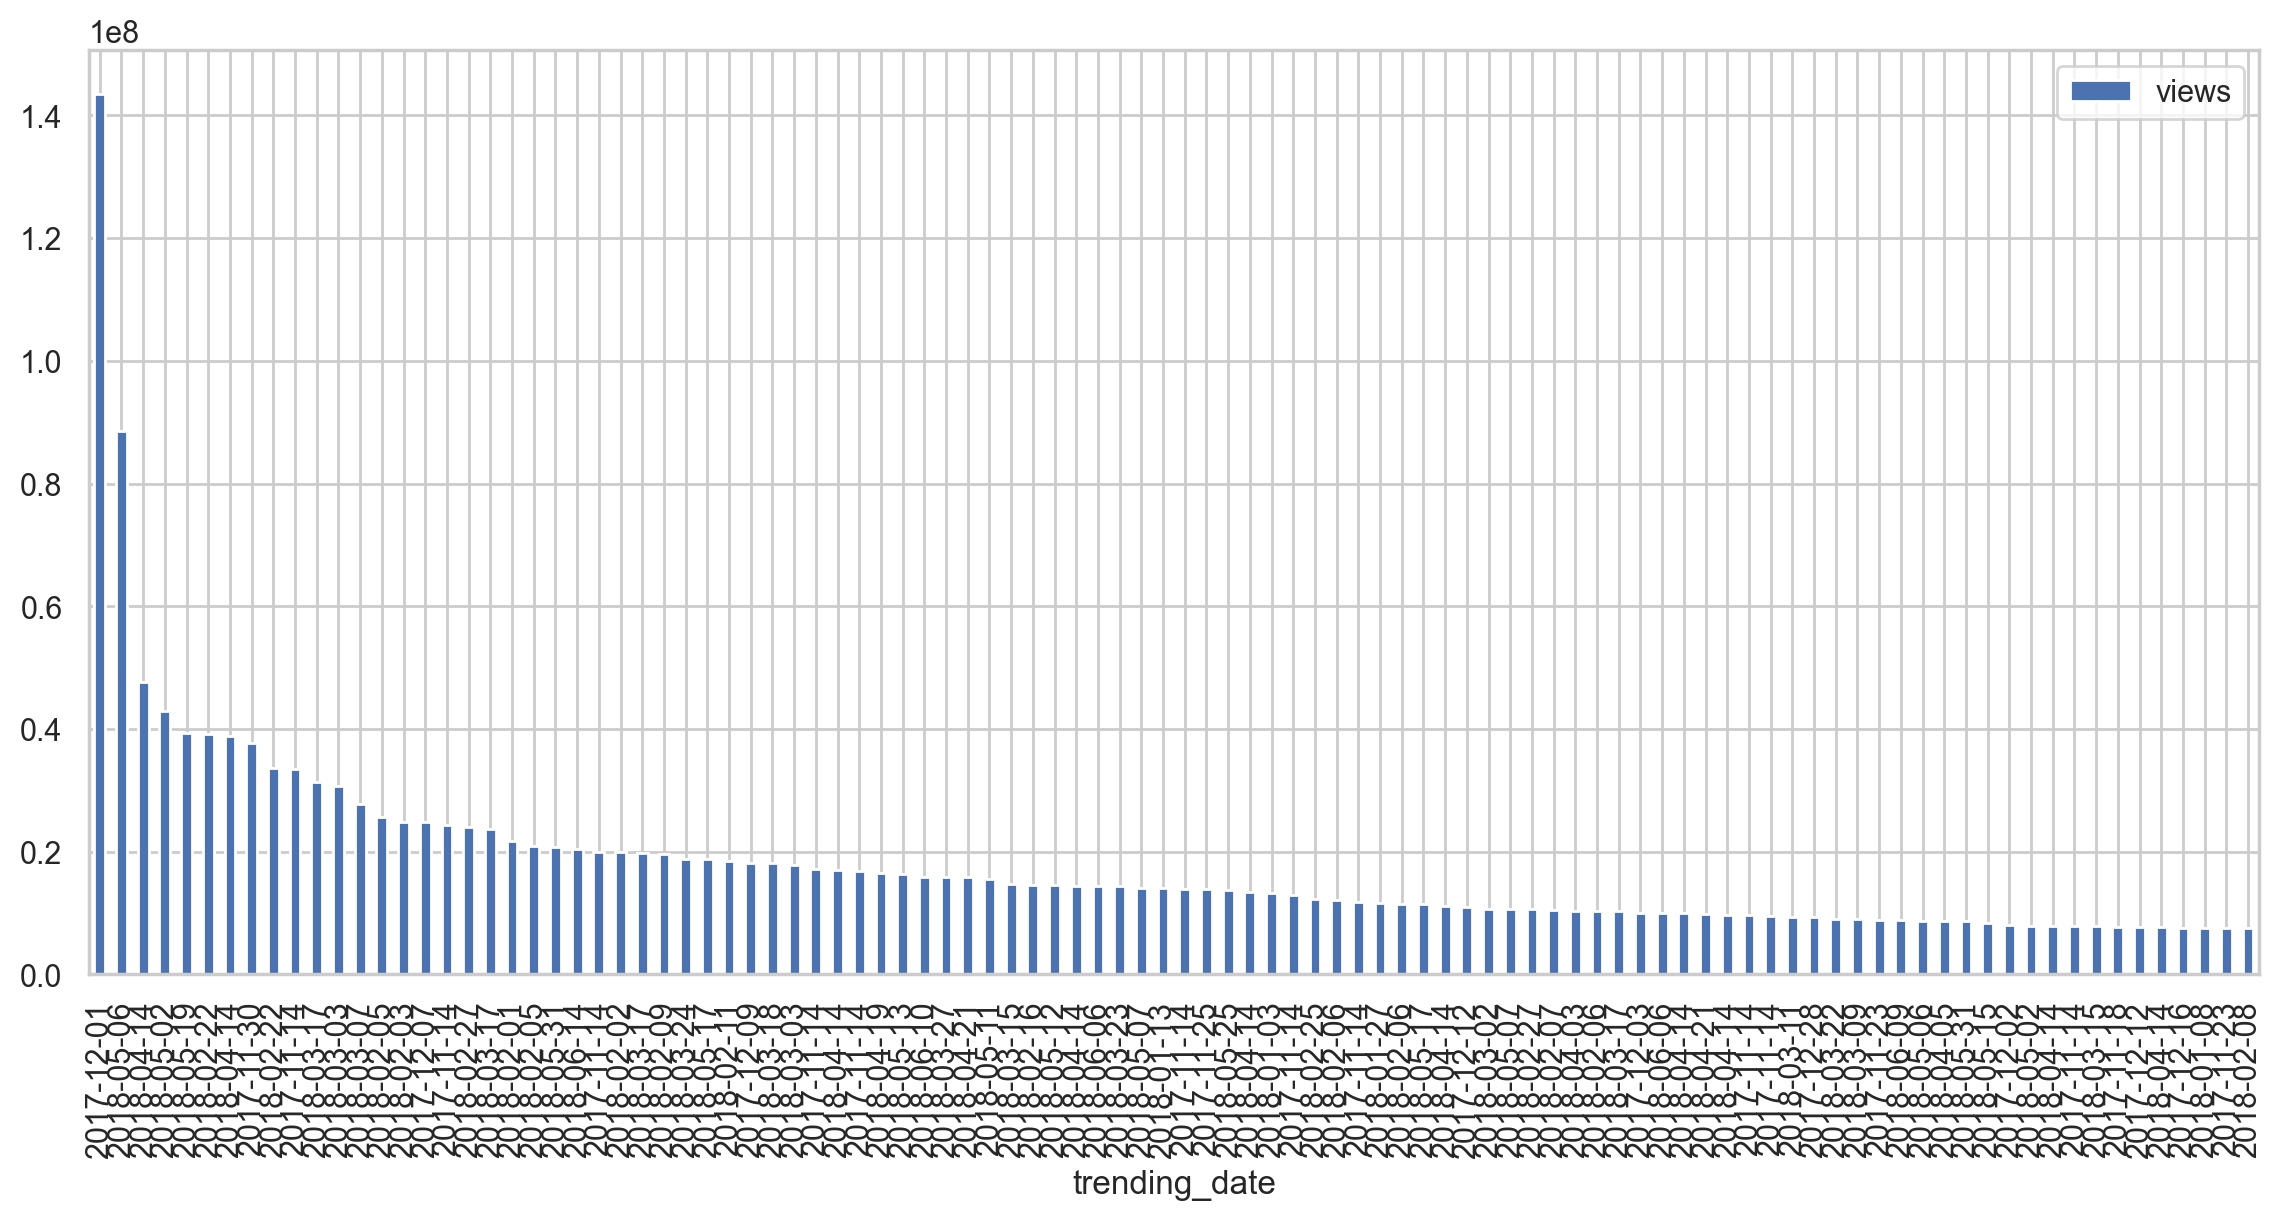

In [59]:
# Plot giữa số view của các video khi vào trending_date ngày đầu xếp giảm dần lấy 100 cái đầu
first_trending_plot = first_trending_df.orderBy(F.desc("views")).limit(100).select("trending_date", "views").toPandas()
first_trending_plot.plot.bar(x="trending_date", figsize=(14, 6))

In [60]:
# Plot thời gian từ khi upload đến khi vào trending
first_trending_df = first_trending_df.withColumn("days_since_upload", F.datediff(F.col("trending_date"), F.col("publish_date")))
first_trending_df.show(10)

+-----------+------------+-------+------+-------------+-------------+-----------------+-----------------+
|   video_id|publish_date|  views| likes|comment_count|trending_date|publish_time_only|days_since_upload|
+-----------+------------+-------+------+-------------+-------------+-----------------+-----------------+
|     #NAME?|  2017-11-10|1164201| 57309|          624|   2017-11-14|         19:19:43|                4|
|-3VBPAZPTQI|  2017-12-29| 209192| 11119|          740|   2017-12-31|         15:11:23|                2|
|-43MBOJnVks|  2018-02-13| 544638|  7985|         1038|   2018-02-14|         17:00:07|                1|
|-5WBCrazSfg|  2017-11-27| 172090|  4354|          587|   2017-11-29|         19:44:49|                2|
|-5aaJJQFvOg|  2018-02-21| 509454| 82757|         4535|   2018-02-24|         22:01:06|                3|
|-7tSTUR7FG0|  2018-02-27|1092530|152536|         8272|   2018-02-28|         12:00:00|                1|
|-8X32zNup1o|  2018-05-21| 513127|  6414|     

In [61]:
first_trending_df.count()

3231

In [62]:
# bỏ các row có giá trị NULL đi
df_cleaned = first_trending_df.dropna()
df_cleaned.orderBy(F.asc("days_since_upload")).show(100)

+-----------+------------+-------+------+-------------+-------------+-----------------+-----------------+
|   video_id|publish_date|  views| likes|comment_count|trending_date|publish_time_only|days_since_upload|
+-----------+------------+-------+------+-------------+-------------+-----------------+-----------------+
|0SLu6i6Rm2g|  2018-01-20|  15235|   211|          126|   2018-01-20|         00:01:44|                0|
|2XPF3Snm9JE|  2018-01-29| 104904| 12698|         2421|   2018-01-29|         01:27:52|                0|
|2z3EUY1aXdY|  2018-02-05|2027569| 50251|        14413|   2018-02-05|         01:51:53|                0|
|4FgV0yBZG6E|  2017-11-29|  30244|  2178|          213|   2017-11-29|         05:06:35|                0|
|8JnfIa84TnU|  2018-05-31| 471533| 67576|         3844|   2018-05-31|         09:00:13|                0|
|E5yFcdPAGv0|  2018-05-31| 722936|176659|        20647|   2018-05-31|         15:57:04|                0|
|FIFLT8iTyJk|  2018-01-29|  38126|  1925|     

In [63]:
# đếm số lượng video upload được vào trending luôn
publish_trending = df_cleaned.filter(F.col("days_since_upload") == 0).count()
print(publish_trending)

56


khi vào trending lượng views có thể không cao

<Axes: xlabel='trending_date'>

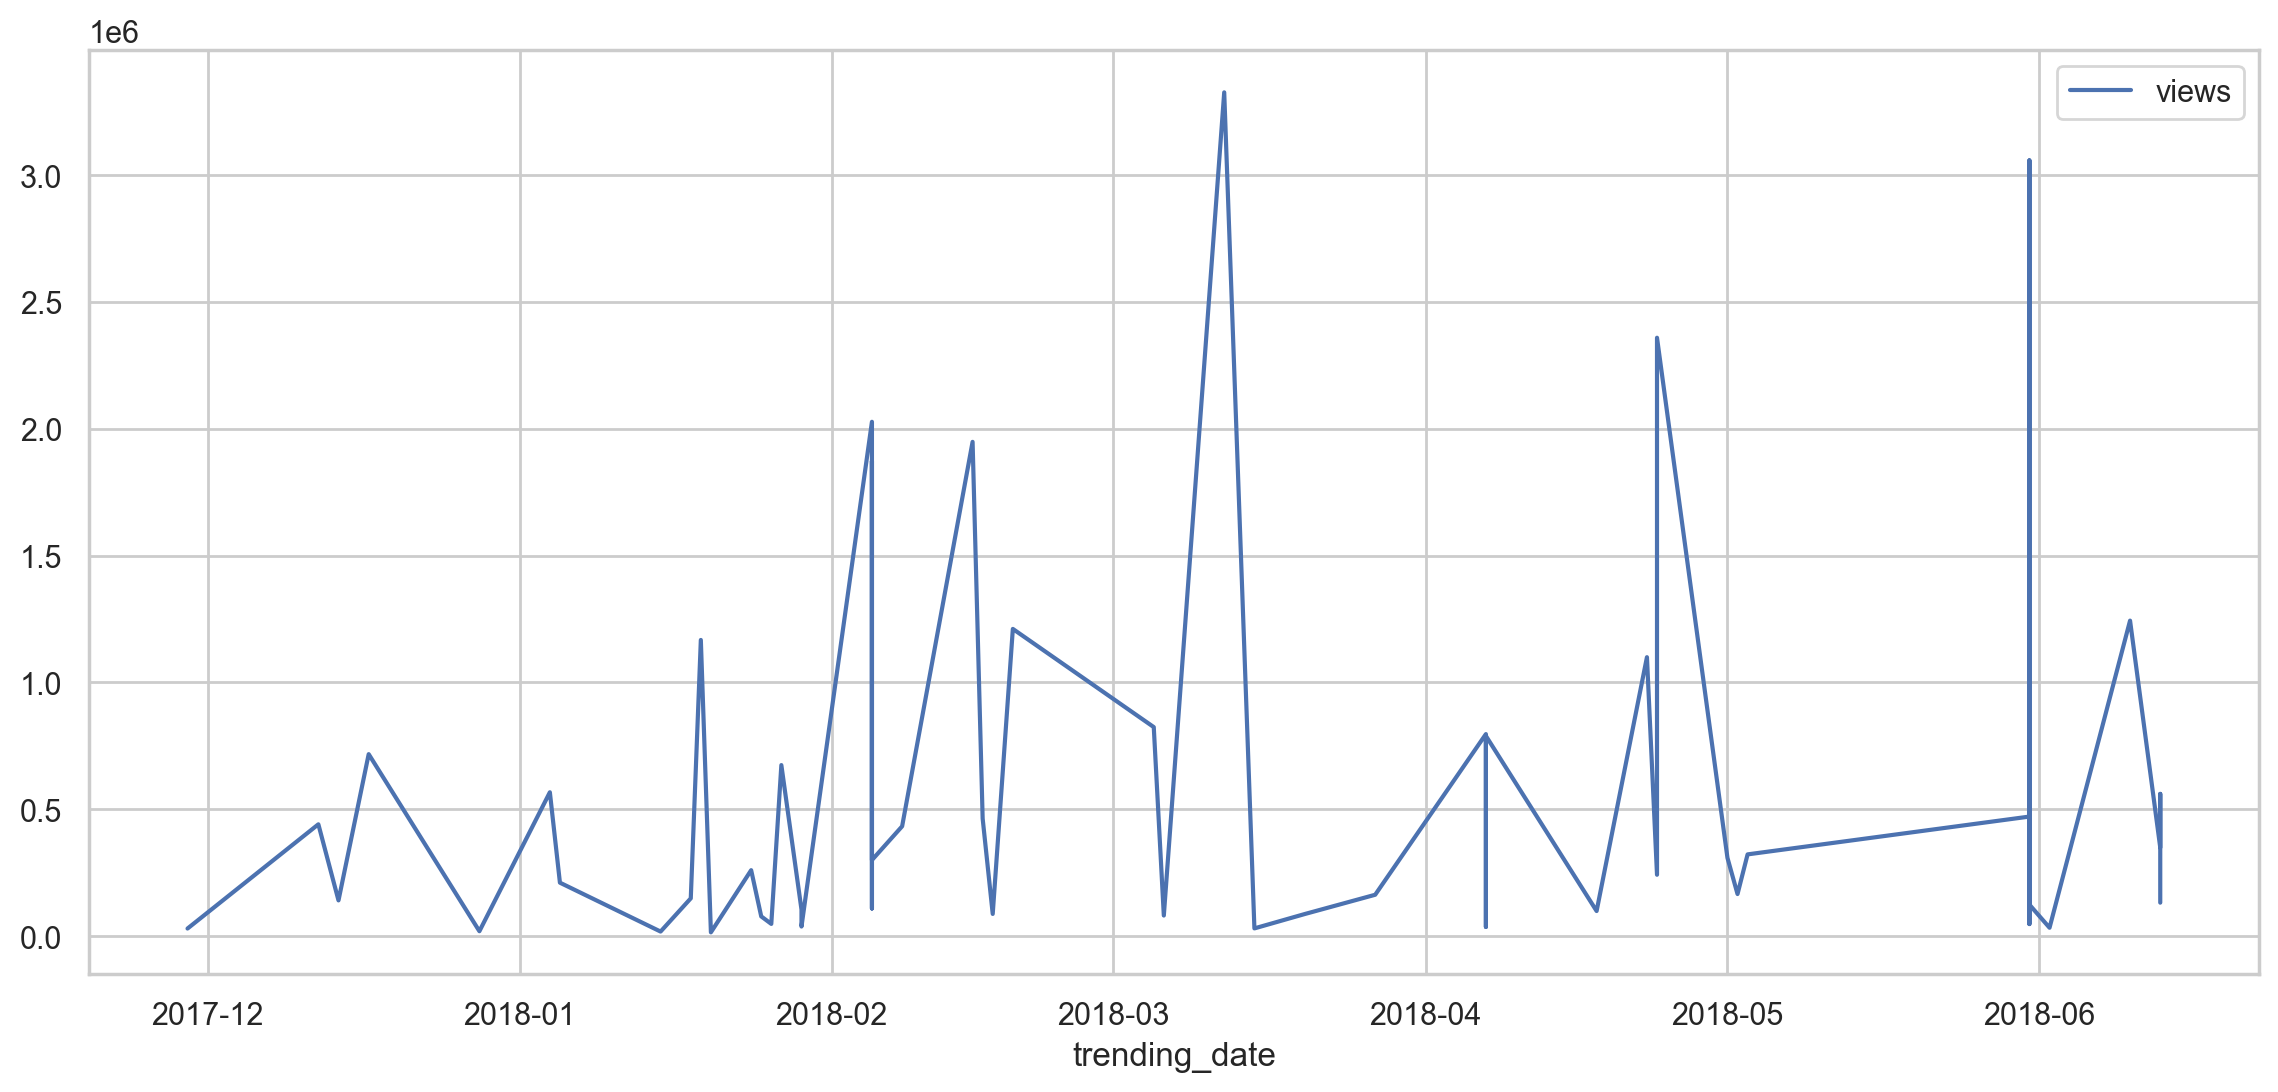

In [64]:
# Plot số view của các video vào trending ngay ngày upload
publish_trending = df_cleaned.filter(F.col("days_since_upload") == 0).orderBy(F.asc("trending_date"))
publish_trending.select("trending_date", "views").toPandas().plot.line(x= "trending_date", figsize=(14, 6))

In [65]:
# Tạo thêm cột hour cho dễ
from pyspark.sql.functions import substring
hour_only = df_cleaned.withColumn("hour", substring(col("publish_time_only"), 1, 2))
hour_only.show(5)

+-----------+------------+-------+-----+-------------+-------------+-----------------+-----------------+----+
|   video_id|publish_date|  views|likes|comment_count|trending_date|publish_time_only|days_since_upload|hour|
+-----------+------------+-------+-----+-------------+-------------+-----------------+-----------------+----+
|     #NAME?|  2017-11-10|1164201|57309|          624|   2017-11-14|         19:19:43|                4|  19|
|-3VBPAZPTQI|  2017-12-29| 209192|11119|          740|   2017-12-31|         15:11:23|                2|  15|
|-43MBOJnVks|  2018-02-13| 544638| 7985|         1038|   2018-02-14|         17:00:07|                1|  17|
|-5WBCrazSfg|  2017-11-27| 172090| 4354|          587|   2017-11-29|         19:44:49|                2|  19|
|-5aaJJQFvOg|  2018-02-21| 509454|82757|         4535|   2018-02-24|         22:01:06|                3|  22|
+-----------+------------+-------+-----+-------------+-------------+-----------------+-----------------+----+
only showi

In [66]:
# Phân tích giờ nào up thì vào trending NHIỀU nhất
hour_trending = hour_only.groupBy("hour").count().orderBy(F.asc("hour"))
hour_trending.show(10)

+----+-----+
|hour|count|
+----+-----+
|  00|  100|
|  01|   93|
|  02|  105|
|  03|   98|
|  04|  138|
|  05|  149|
|  06|   61|
|  07|   57|
|  08|  101|
|  09|  131|
+----+-----+
only showing top 10 rows



<Axes: xlabel='hour'>

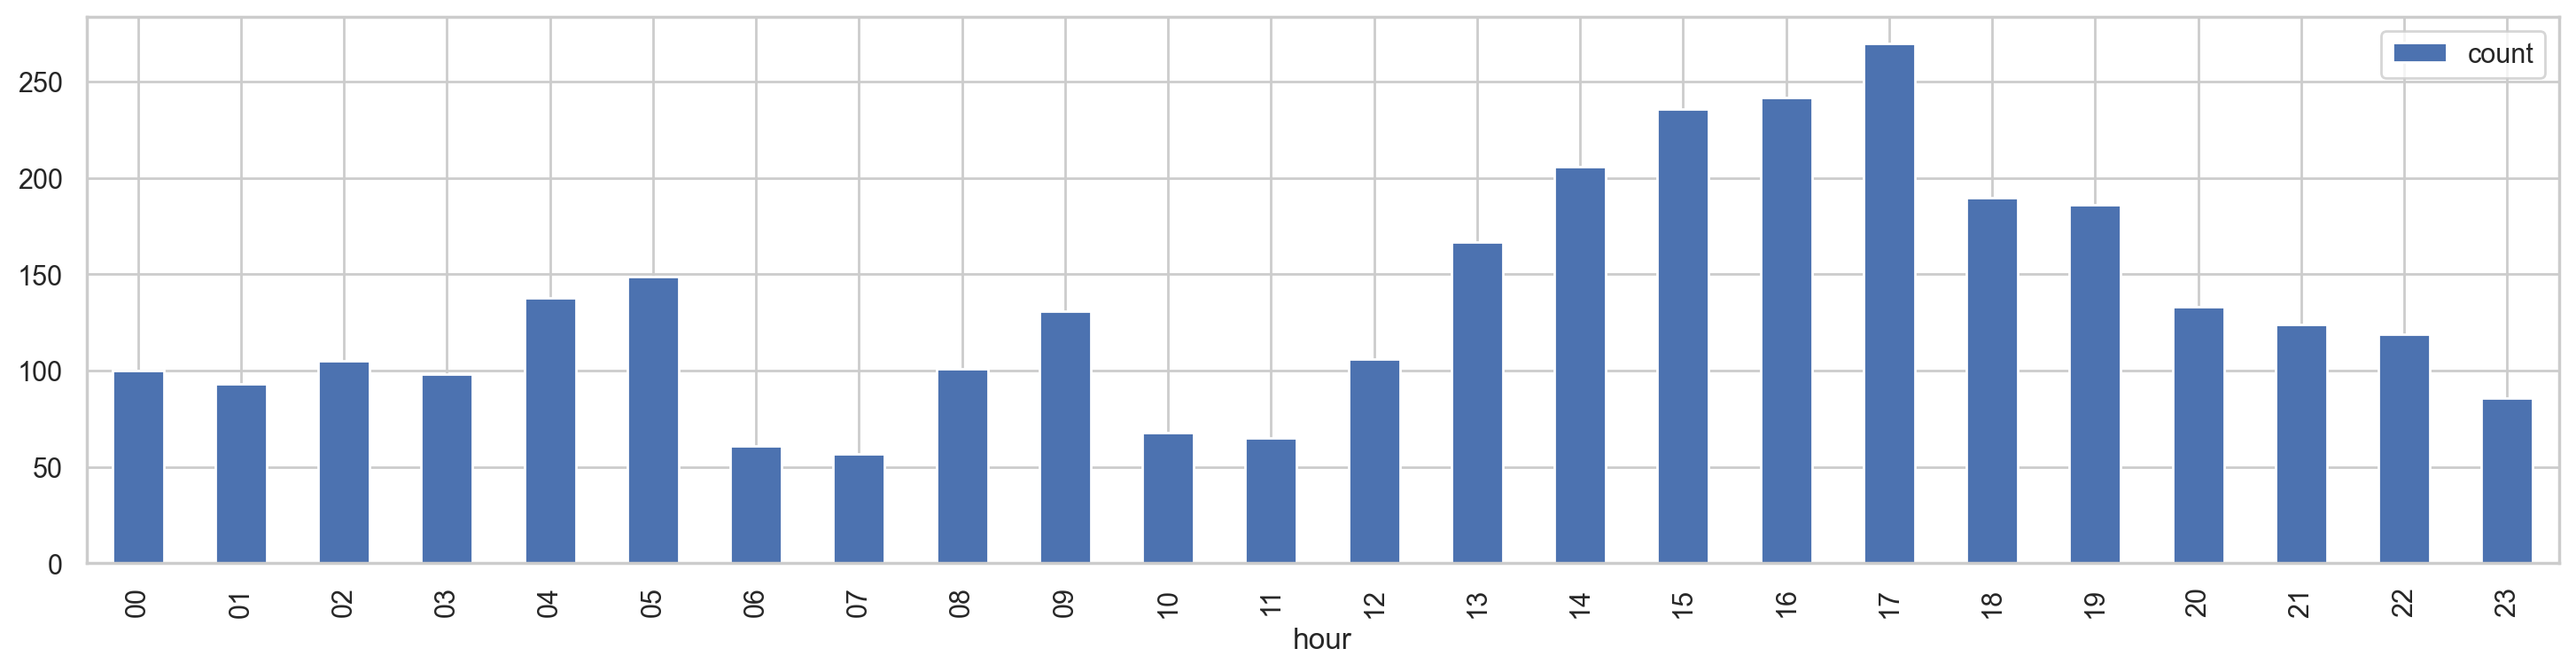

In [67]:
# Plot hour_trending
hour_trending.toPandas().plot.bar(x="hour", y="count")

<Axes: xlabel='hour'>

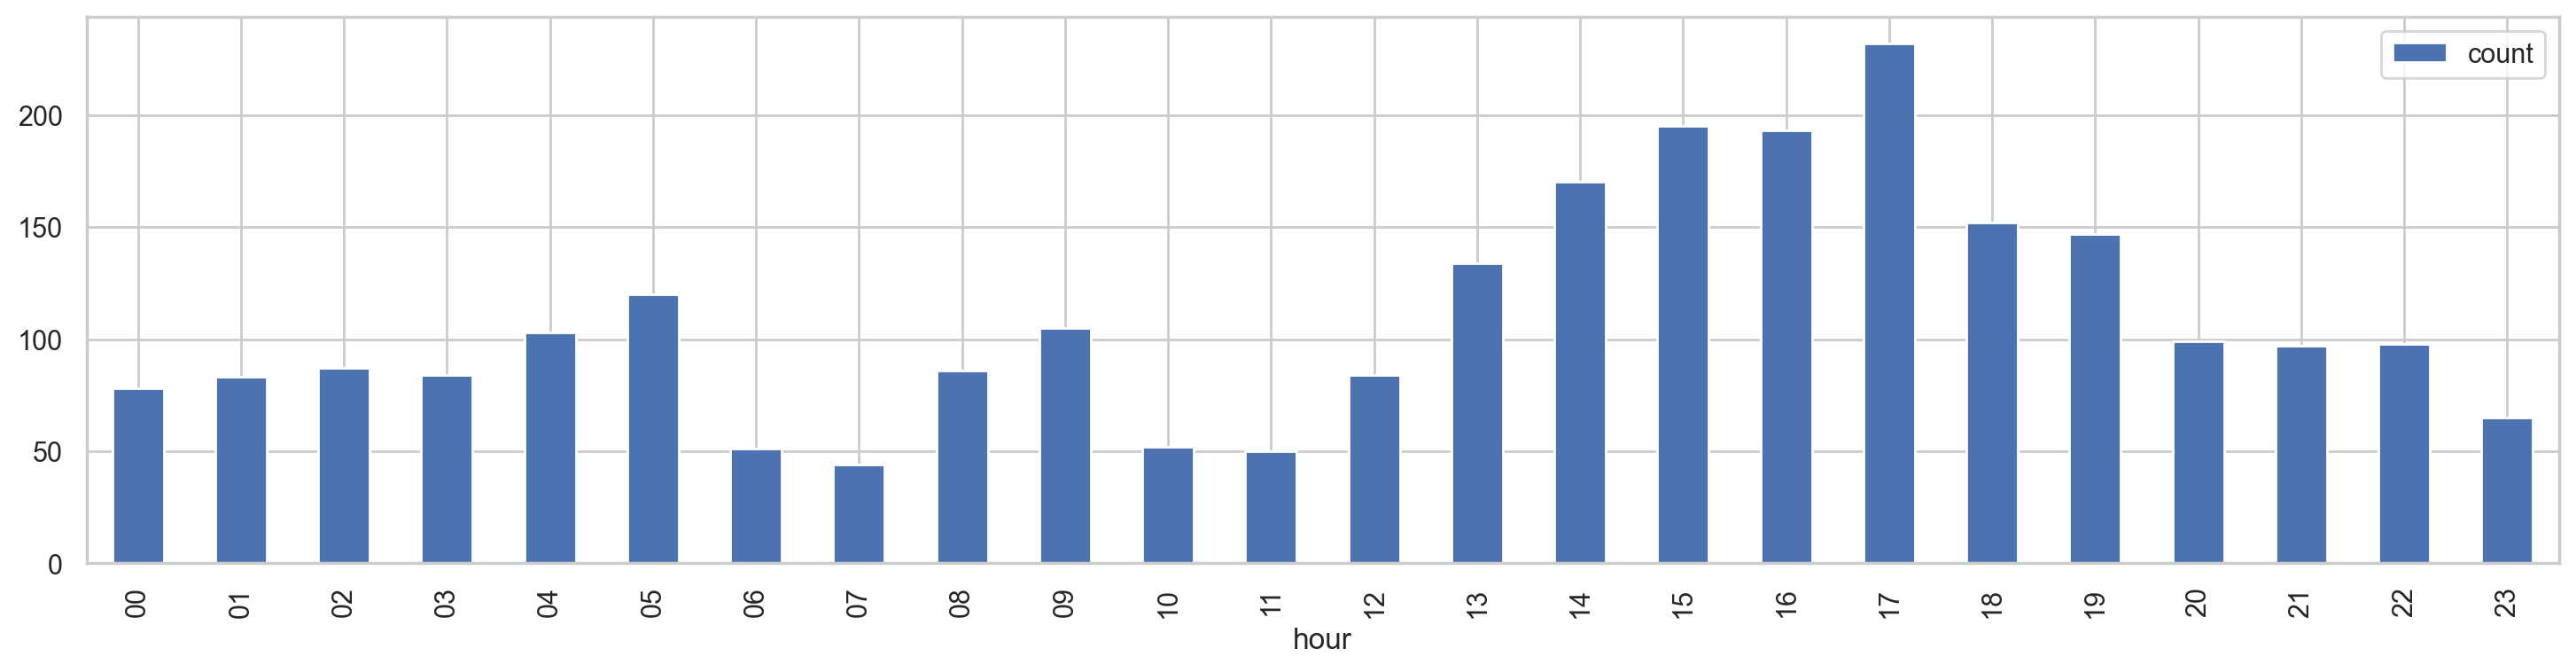

In [68]:
# Plot upload giờ nào thì vào trending NHANH nhất, bé hơn hoặc bằng 5 ngày
max_days = hour_only.filter(F.col("days_since_upload") <= 5).groupBy("hour").count().orderBy(F.asc("hour"))
max_days.toPandas().plot.bar(x="hour", y="count")

<Axes: xlabel='publish_time_only'>

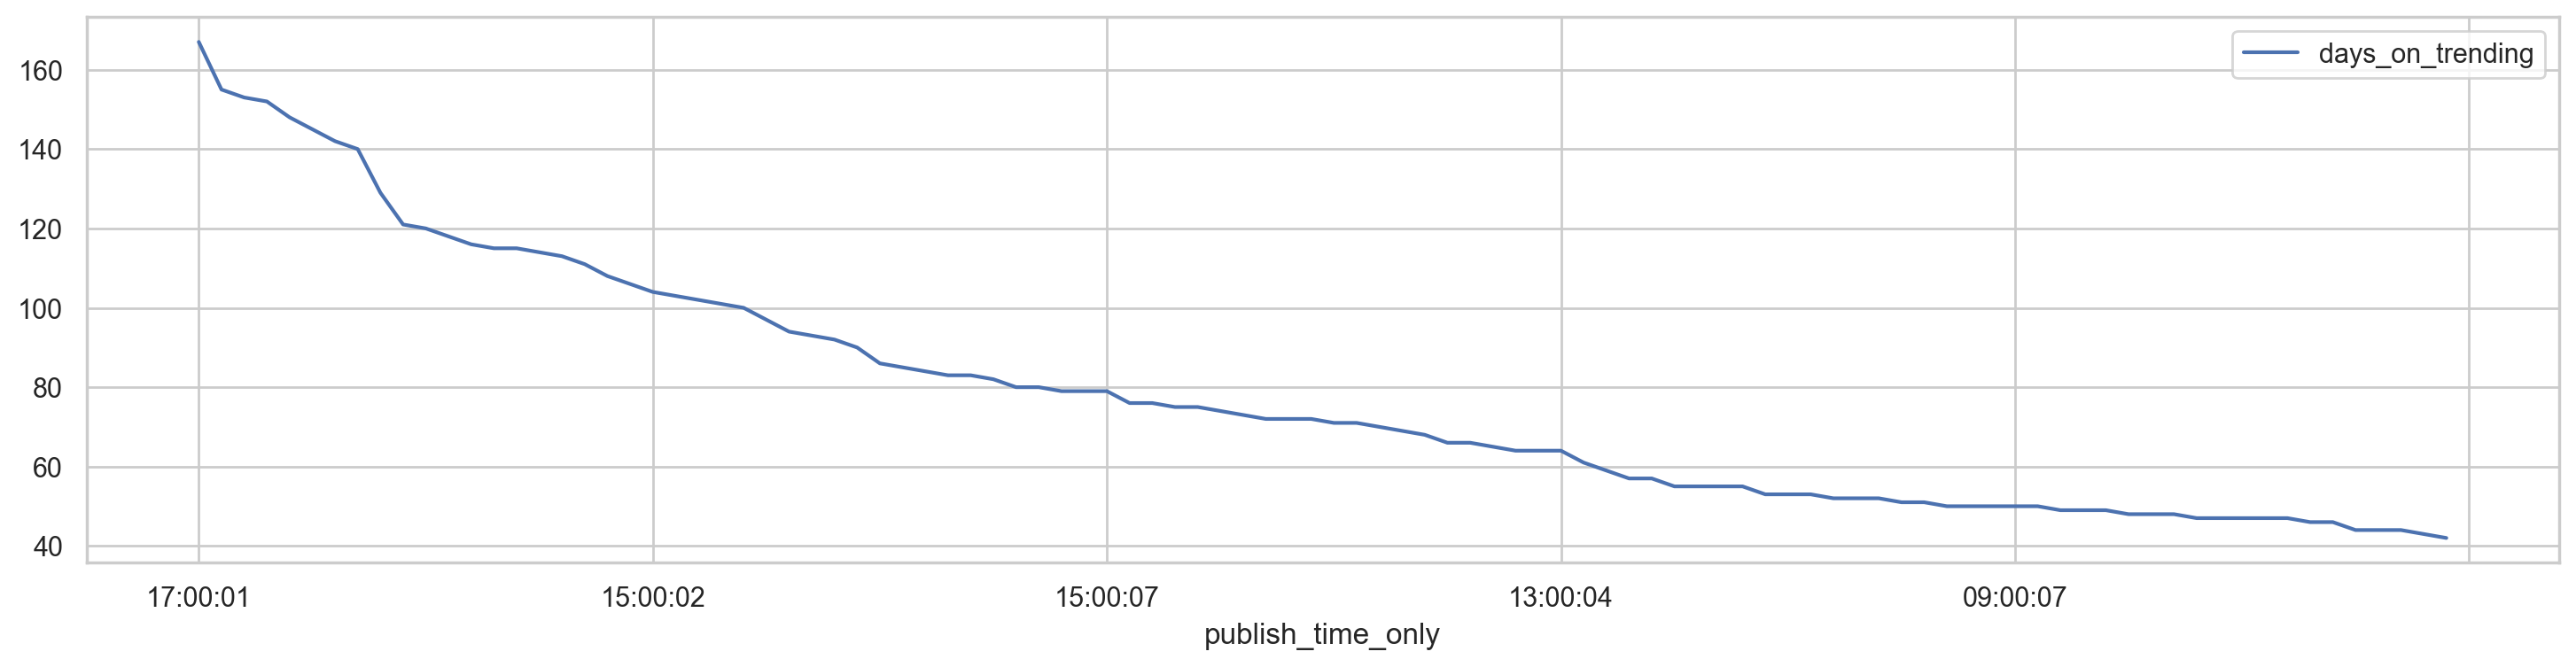

In [69]:
# Phân tích thời gian tồn tại trên trending dựa trên thời điểm upload
from pyspark.sql.functions import countDistinct
trending_duration_df = views_time_df.groupBy("publish_time_only").agg(
    countDistinct("trending_date").alias("days_on_trending")
)
trending_duration_df = trending_duration_df.orderBy(F.desc("days_on_trending")).limit(100)
trending_duration_df.toPandas().plot.line(x="publish_time_only", y="days_on_trending")

<Axes: xlabel='hour'>

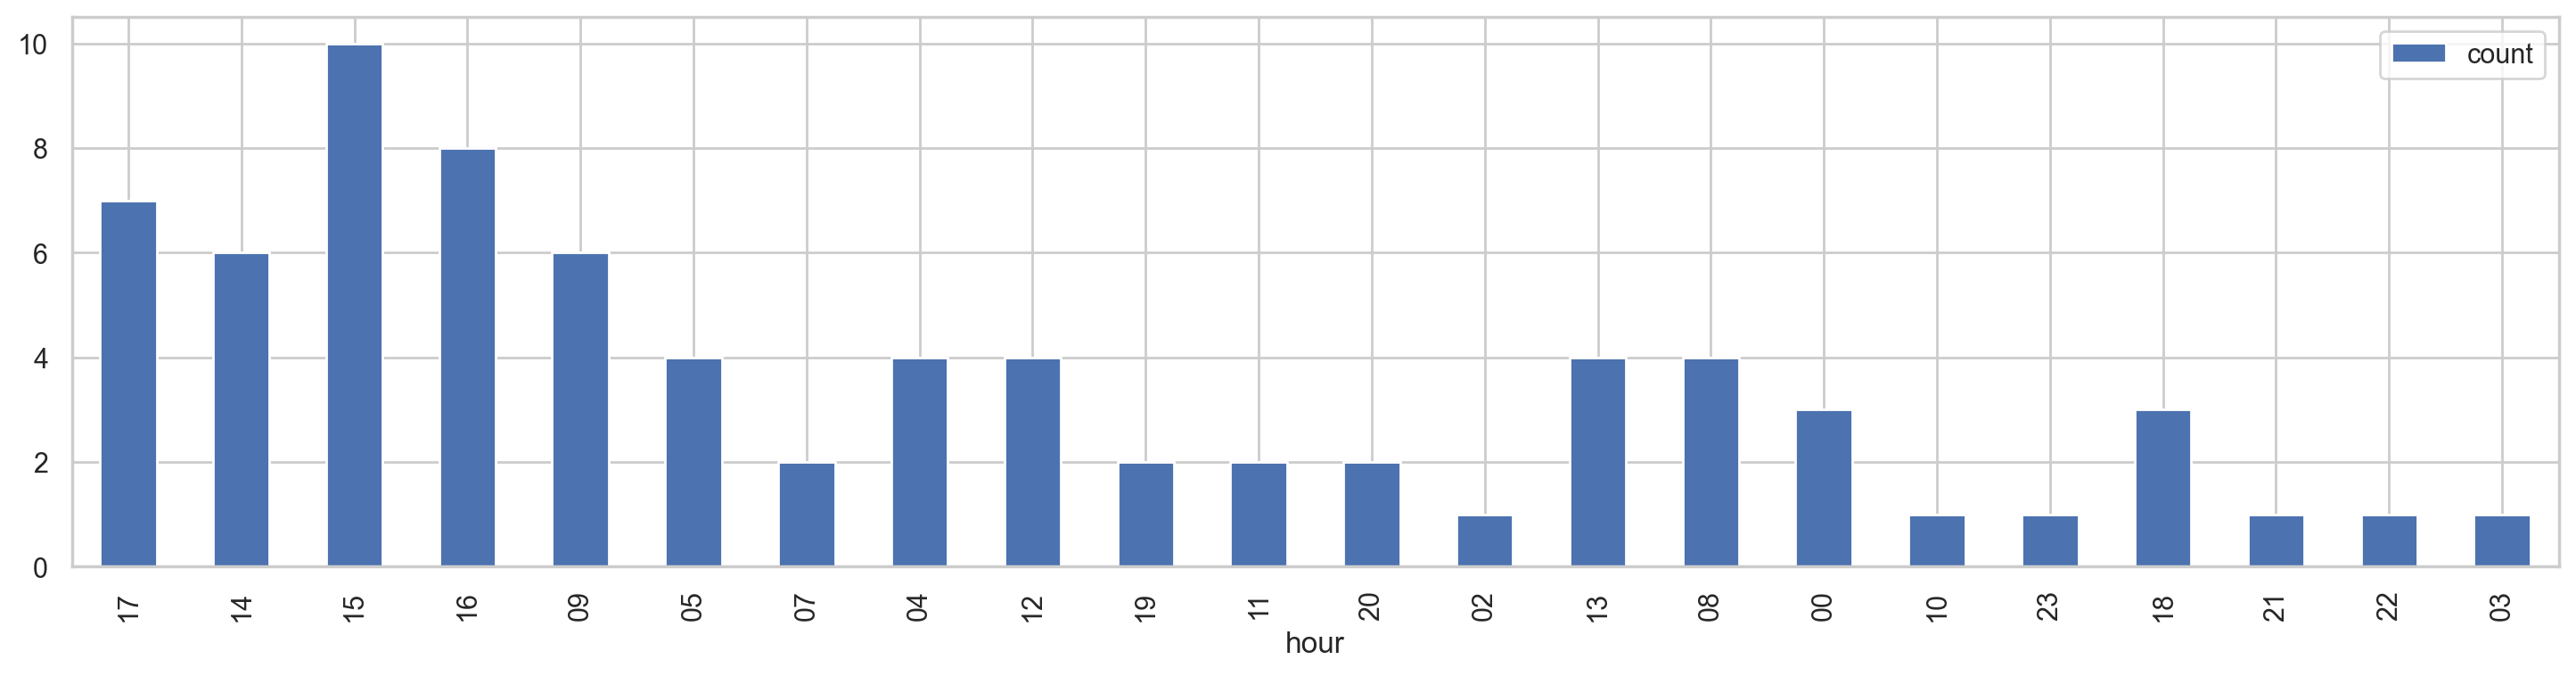

In [70]:
# Thời gian nào trong ngày upload thì được trên trending LÂU nhất, dùng hour cho dễ, lâu được tính là các video trên trending > 50 ngày.
hour_trending_duration = trending_duration_df.withColumn("hour", substring(col("publish_time_only"), 1, 2))
hour_trending_duration = hour_trending_duration.filter(F.col("days_on_trending") > 50).groupBy("hour").count()
hour_trending_duration.toPandas().plot.bar(x="hour")